# This notebook is used ~~solely~~ for visualisation purposes and debugging

In [15]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import of necessary libraries

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import ssl

from osgeo import gdal
import geopandas as gpd
import shapely

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.preprocessing import Normalizer

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.data_utils as du
import utils.sp_utils as sp



In [3]:
# User modules

from utils.models import senet
from utils.models import modules
from utils.models import net

In [11]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [12]:
UMP = [
     # "AverageHeightArea", 
     # "AverageHeightBuilding", 
     "AverageHeightTotalArea", 
#      "Displacement", 
     "FrontalAreaIndex",
     # "MaximumHeight",
     # "PercentileHeight",
     "PlanarAreaIndex",
#      "RoughnessLength",
     "StandardDeviation"
     ]

UMP_OLD = ['height_avg_area', 'height_avg_bld', 'height_avg_total', 'frontal_index', 'height_max',
       'height_percentile', 'planar_index', 'height_std']

UMP_OLD_UNSORTED = ['height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
       'height_max', 'height_percentile', 'planar_index', 'frontal_index']

In [13]:
def LL_polygon(x, y, width= 1000):
    """
    Returns a square polygon of set width with only the Lower Left coodinates
    """
    return shapely.Polygon([i.coords[0] for i in sp.generateCorners((x, y), step = width)])

## Load data

In [4]:
# Grid

## UMPS
# Osaka
#osaka_gdf = gpd.read_feather("data/Y_UMP/Y_osaka_7.feather")
#osaka_gdf.columns

# Tokyo
tokyo_gdf = gpd.read_feather("/gucnas2/jiang/Tokyo_shp/Y_UMP/Y_tokyo_3.feather")
tokyo_gdf.columns
#with open("/gucnas2/jiang/Tokyo_shp/Y_UMP/ds_tokyo_distinct.pkl, "rb") as f:
    #ds_tokyo_distinct = pickle.load(f)

# Old Labels
labels_df = pd.read_csv("/gucnas2/jiang/Tokyo_shp/Y_UMP/tokyo_ump.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/gucnas2/jiang/Tokyo_shp/Y_UMP/tokyo_ump.csv'

In [8]:
# NY
ny_gdf = gpd.read_feather("data/Y_UMP/Y_ny.feather")

In [21]:
with open("data/ds_tokyo_3.pkl", "rb") as f:
    ds_tokyo = pickle.load(f)

with open("data/ds_osaka_3.pkl", "rb") as f:
    ds_osaka = pickle.load(f)
with open("data/ds_ny_3.pkl", "rb") as f:
    ds_ny = pickle.load(f)

## Conversion from old to new data

In [30]:
label_df_geom = labels_df.apply(lambda x: LL_polygon(x["x_coord"], x["y_coord"]), axis= 1)
label_df_gdf = gpd.GeoDataFrame(geometry= label_df_geom, data= labels_df.drop(labels_df.columns[:4], axis= 1)[UMP_OLD])
label_df_gdf

height_avg_area  height_avg_bld  height_avg_total  frontal_index  \
0           26.206931        9.430429          9.082073       0.206220   
1           34.327736       13.051634          8.534822       0.121887   
2           26.184764       15.077551          2.226291       0.040740   
3           27.479736       29.800000          0.387221       0.006606   
4            0.000000        0.000000          0.000000       0.000000   
...               ...             ...               ...            ...   
3295        14.593501        8.719214          4.354586       0.269157   
3296        12.399513        8.244629          3.690500       0.250506   
3297        11.311879        7.932749          3.254257       0.244455   
3298        10.615458        7.987299          3.196222       0.240277   
3299         9.895738        7.711106          3.145661       0.232668   

      height_max  height_percentile  planar_index     height_std  \
0           49.7             32.244      0.346552  115846.195627   
1           49.7             44.336      0.248628  266143.703659   
2           49.5             49.500      0.085022   80714.236585   
3           35.3             34.984      0.014091  112338.114797   
4            0.0              0.000      0.000000       0.000000   
...          ...                ...           ...            ...   
3295        90.5             26.658      0.298392   15883.773693   
3296        55.9             22.900      0.297633    7950.307778   
3297        40.8             20.992      0.287685    4714.404151   
3298        40.8             21.168      0.301091    4069.347920   
3299        32.0             15.792      0.317880    6098.725963   

                                                                                                                                          geometry  
0     POLYGON ((15556169.000 4239090.000, 15557169.000 4239090.000, 15557169.000 4240090.000, 15556169.000 4240090.000, 15556169.000 4239090.000))  
1     POLYGON ((15556669.000 4239090.000, 15557669.000 4239090.000, 15557669.000 4240090.000, 15556669.000 4240090.000, 15556669.000 4239090.000))  
2     POLYGON ((15557169.000 4239090.000, 15558169.000 4239090.000, 15558169.000 4240090.000, 15557169.000 4240090.000, 15557169.000 4239090.000))  
3     POLYGON ((15557669.000 4239090.000, 15558669.000 4239090.000, 15558669.000 4240090.000, 15557669.000 4240090.000, 15557669.000 4239090.000))  
4     POLYGON ((15558169.000 4239090.000, 15559169.000 4239090.000, 15559169.000 4240090.000, 15558169.000 4240090.000, 15558169.000 4239090.000))  
...                                                                                                                                            ...  
3295  POLYGON ((15561169.000 4272090.000, 15562169.000 4272090.000, 15562169.000 4273090.000, 15561169.000 4273090.000, 15561169.000 4272090.000))  
3296  POLYGON ((15561669.000 4272090.000, 15562669.000 4272090.000, 15562669.000 4273090.000, 15561669.000 4273090.000, 15561669.000 4272090.000))  
3297  POLYGON ((15562169.000 4272090.000, 15563169.000 4272090.000, 15563169.000 4273090.000, 15562169.000 4273090.000, 15562169.000 4272090.000))  
3298  POLYGON ((15562669.000 4272090.000, 15563669.000 4272090.000, 15563669.000 4273090.000, 15562669.000 4273090.000, 15562669.000 4272090.000))  
3299  POLYGON ((15563169.000 4272090.000, 15564169.000 4272090.000, 15564169.000 4273090.000, 15563169.000 4273090.000, 15563169.000 4272090.000))  

[3300 rows x 9 columns]

In [46]:
label_df_gdf["geometry"].bounds

minx       miny        maxx       maxy
0     15556169.0  4239090.0  15557169.0  4240090.0
1     15556669.0  4239090.0  15557669.0  4240090.0
2     15557169.0  4239090.0  15558169.0  4240090.0
3     15557669.0  4239090.0  15558669.0  4240090.0
4     15558169.0  4239090.0  15559169.0  4240090.0
...          ...        ...         ...        ...
3295  15561169.0  4272090.0  15562169.0  4273090.0
3296  15561669.0  4272090.0  15562669.0  4273090.0
3297  15562169.0  4272090.0  15563169.0  4273090.0
3298  15562669.0  4272090.0  15563669.0  4273090.0
3299  15563169.0  4272090.0  15564169.0  4273090.0

[3300 rows x 4 columns]

In [47]:
# Visualise train and split
label_df_gdf[label_df_gdf["geometry"].bounds["maxx"] < 15563169].to_feather("old_train_cells.feather")
label_df_gdf[label_df_gdf["geometry"].bounds["minx"] > 15563169].to_feather("old_valid_cells.feather")


## Functions for visualisation

### Tokyo Distinct

TypeError: unhashable type: 'numpy.ndarray'

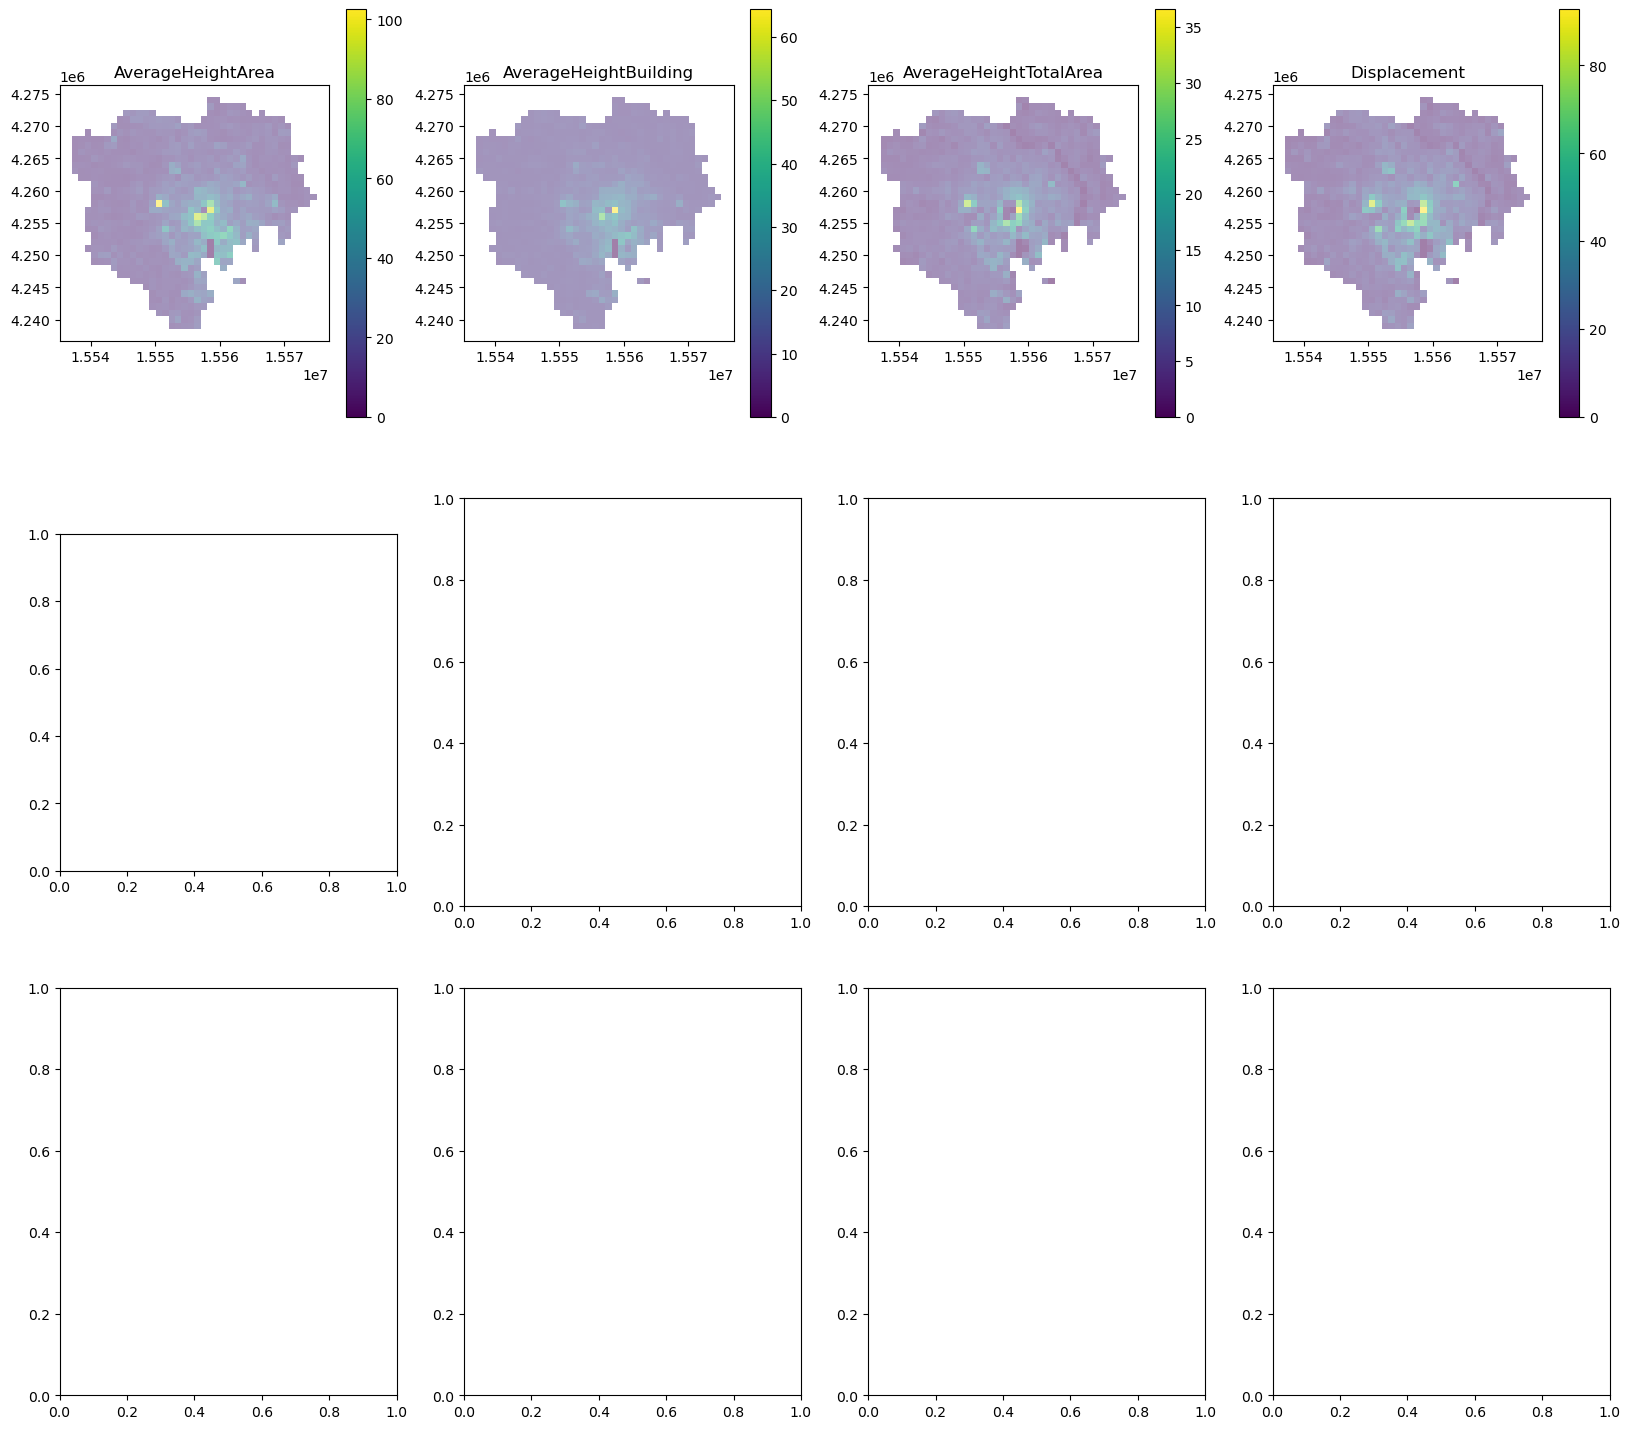

In [9]:
tokyo_gdf = gpd.read_feather("/gucnas2/jiang/Tokyo_shp/Y_UMP/Y_tokyo_3.feather")
du.plotUMP(tokyo_gdf,n_col=4)

IndexError: list index out of range

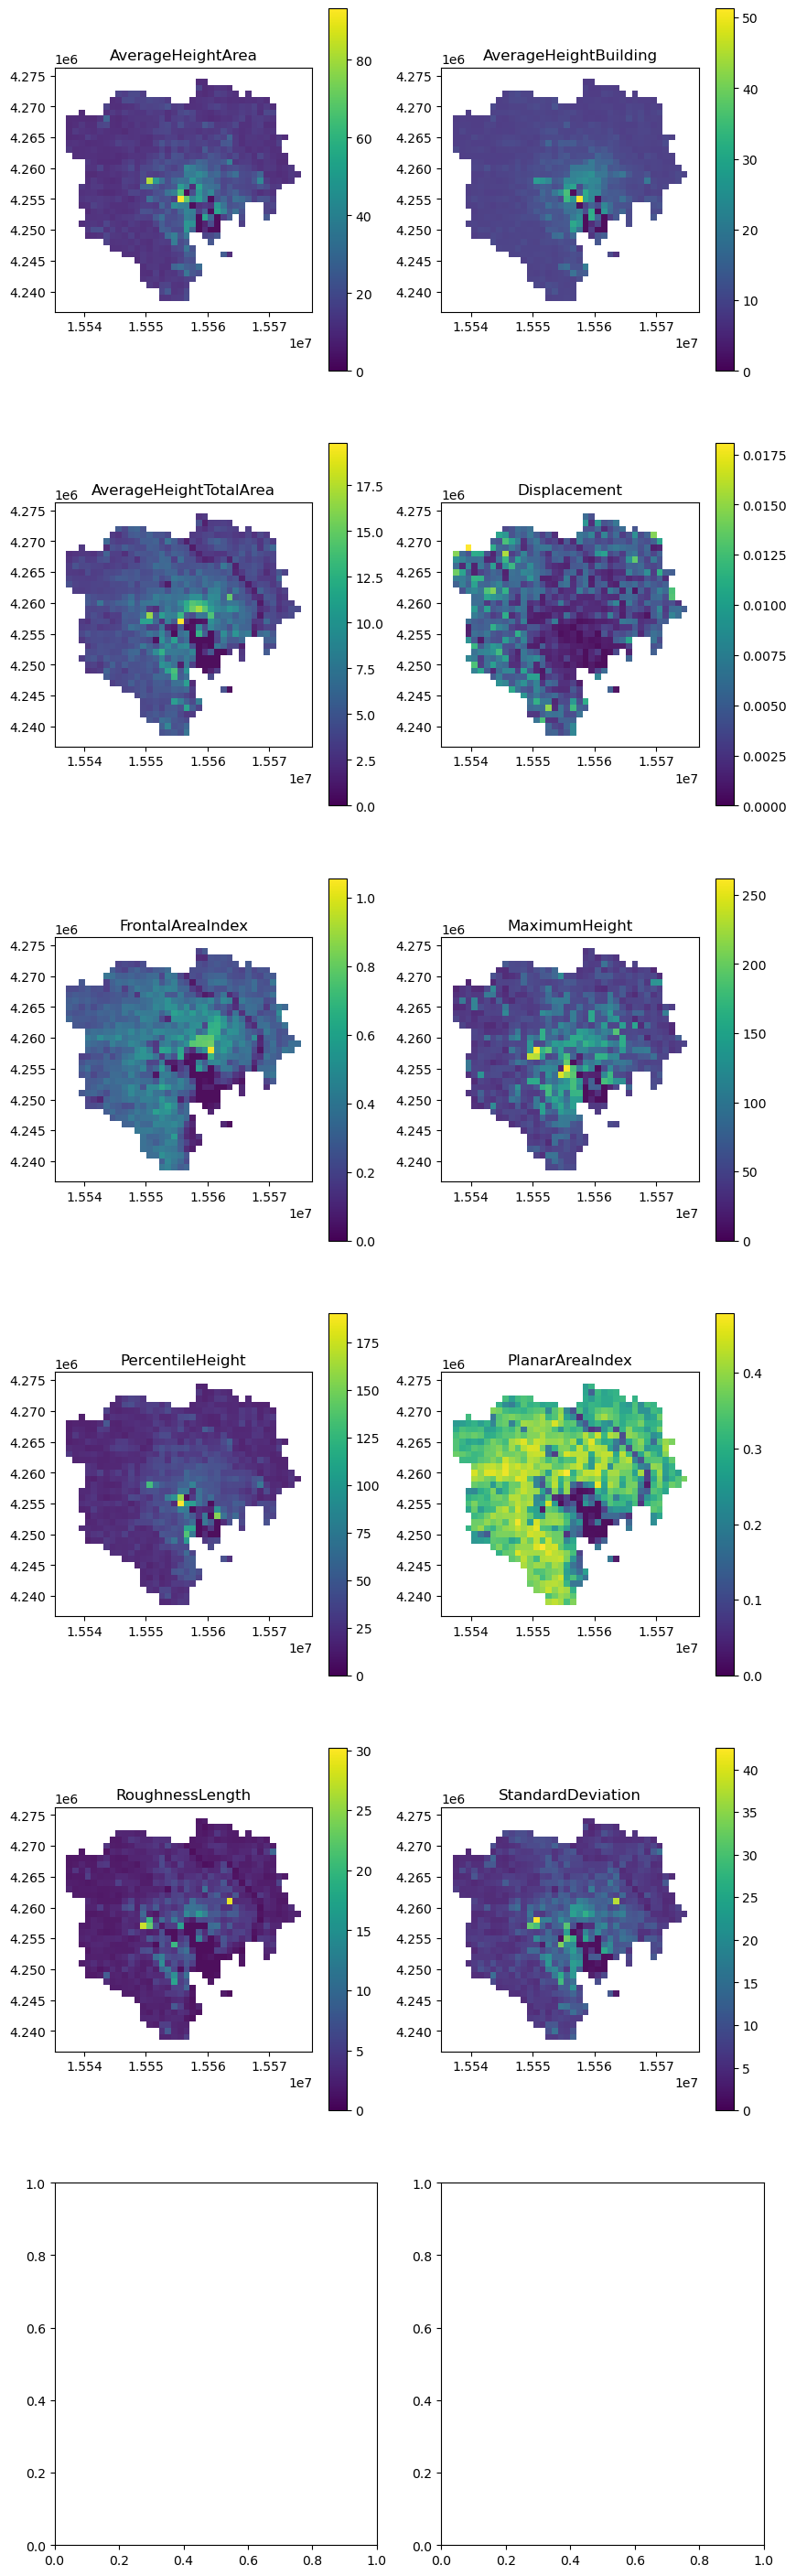

In [12]:
du.plotUMP(ds_tokyo_distinct.ump_df)

### Old Tokyo

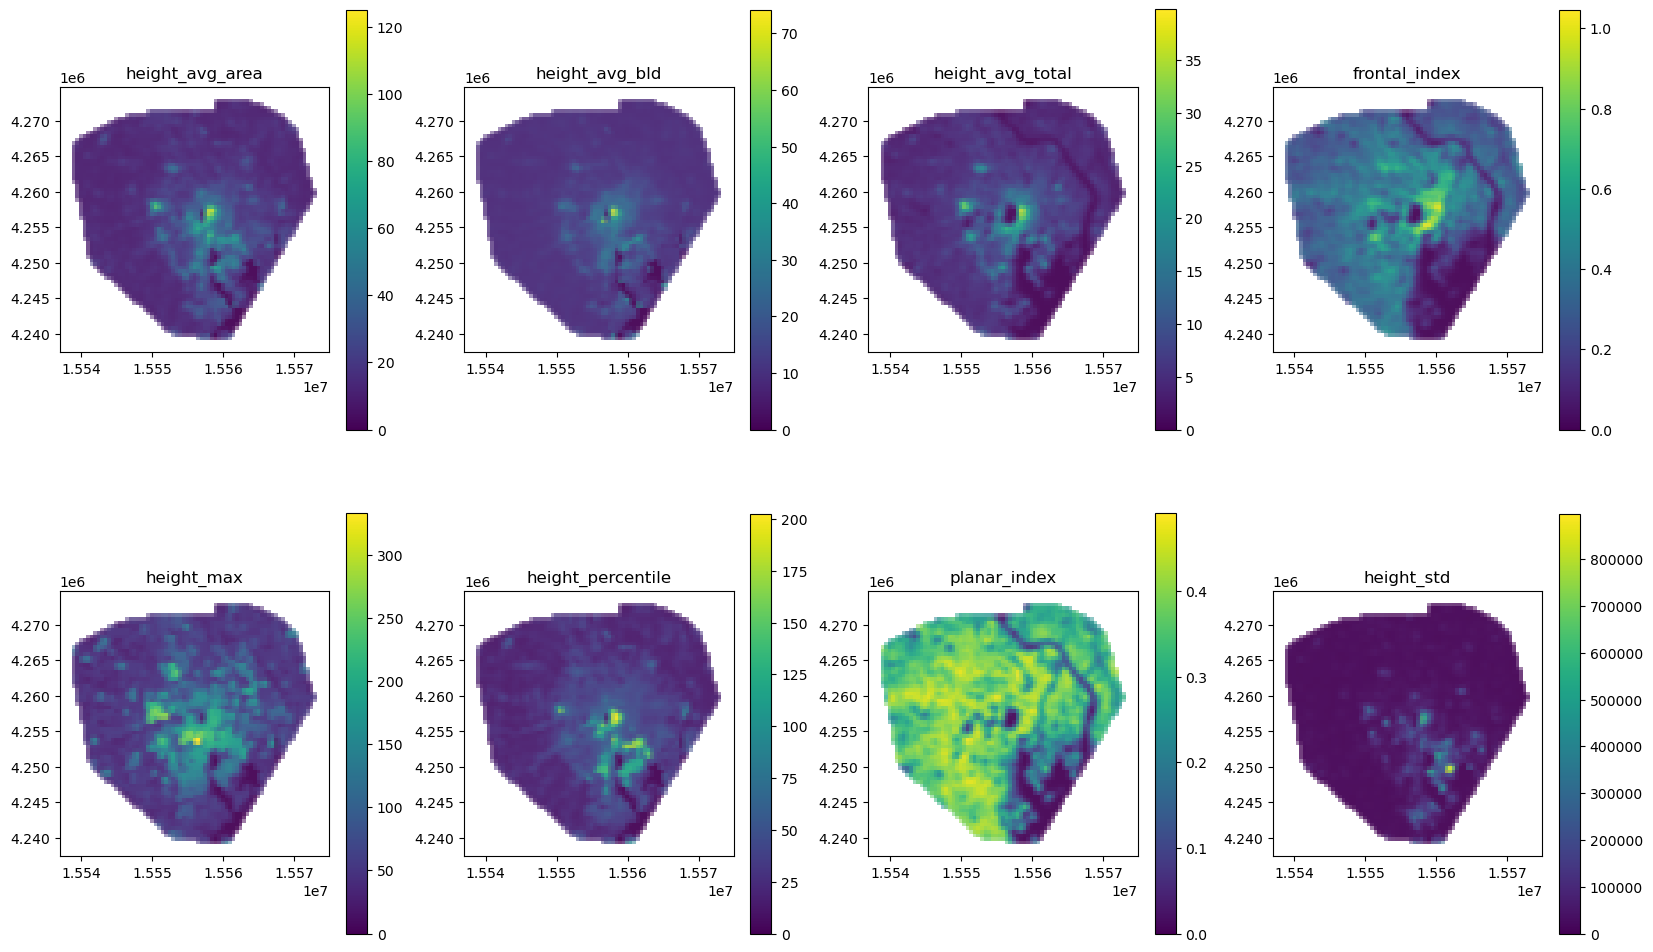

In [35]:
du.plotUMP(label_df_gdf, band_names= label_df_gdf.columns[:-1], n_col= 4)

### Osaka

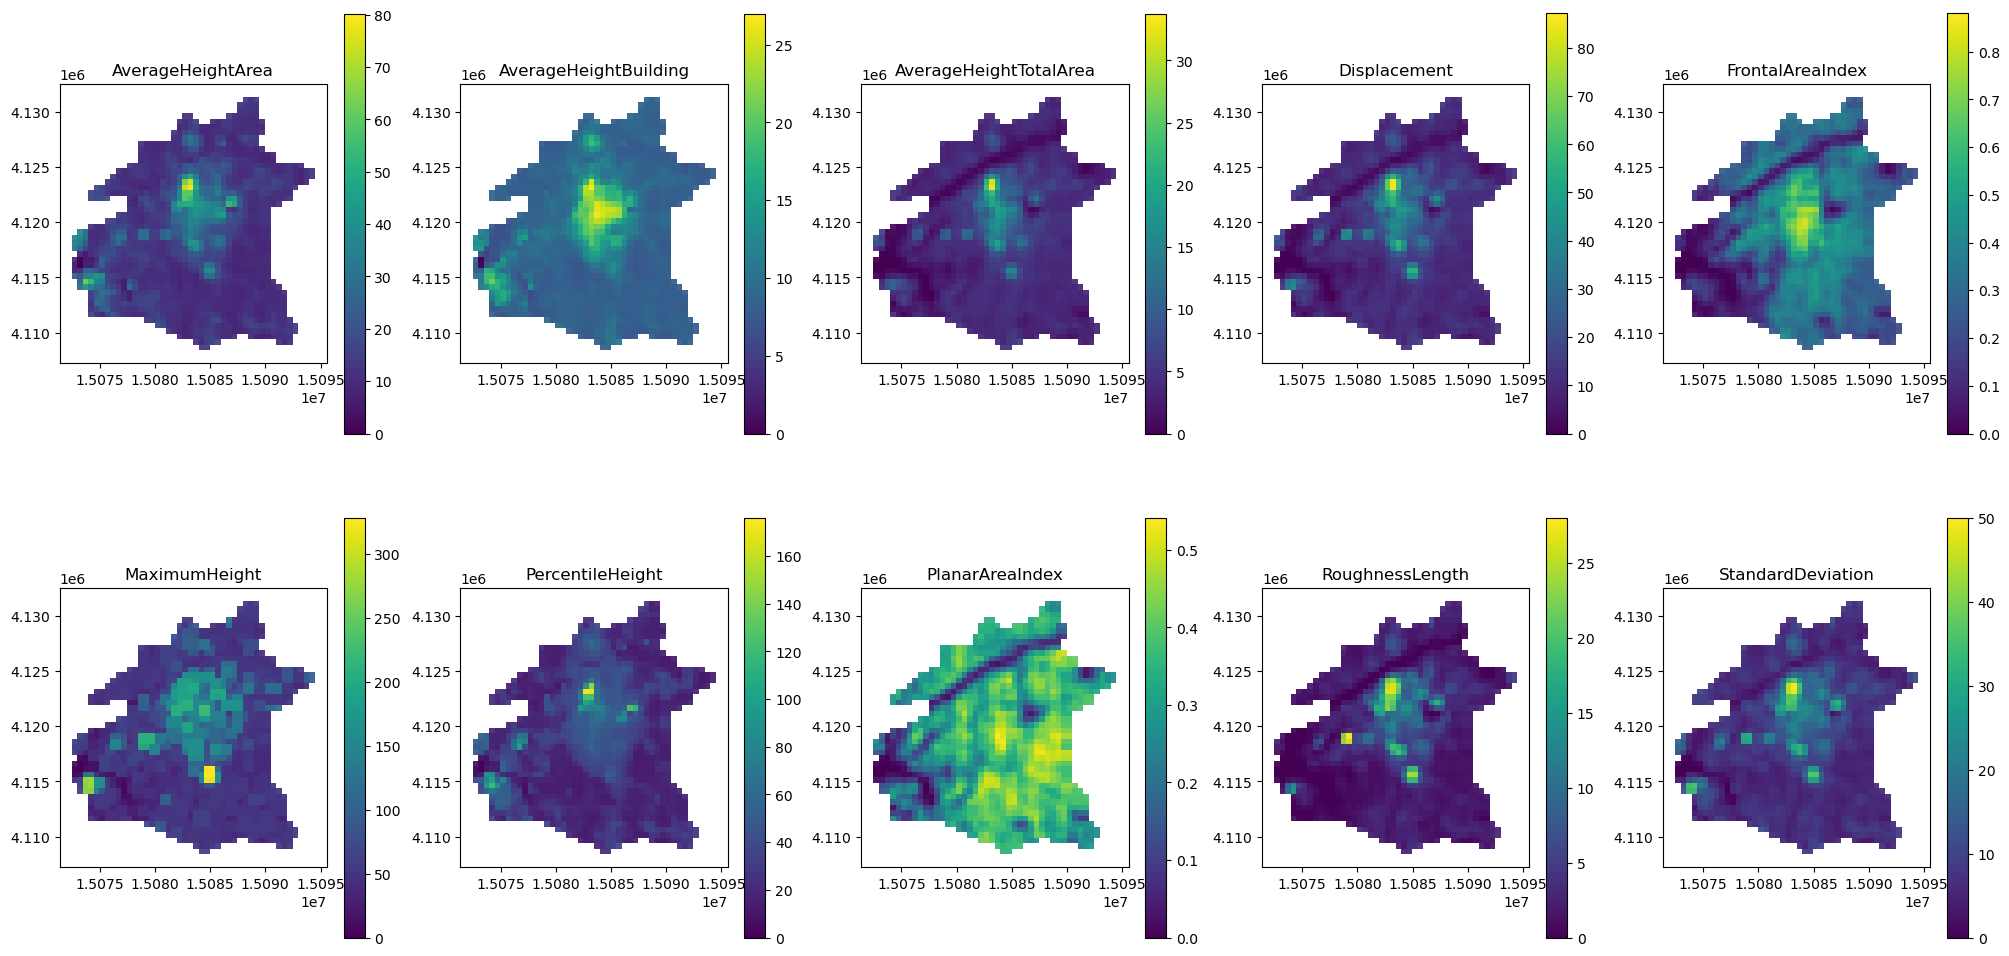

In [11]:
du.plotUMP(ds_osaka.ump_df, n_col= 5)

### Tokyo

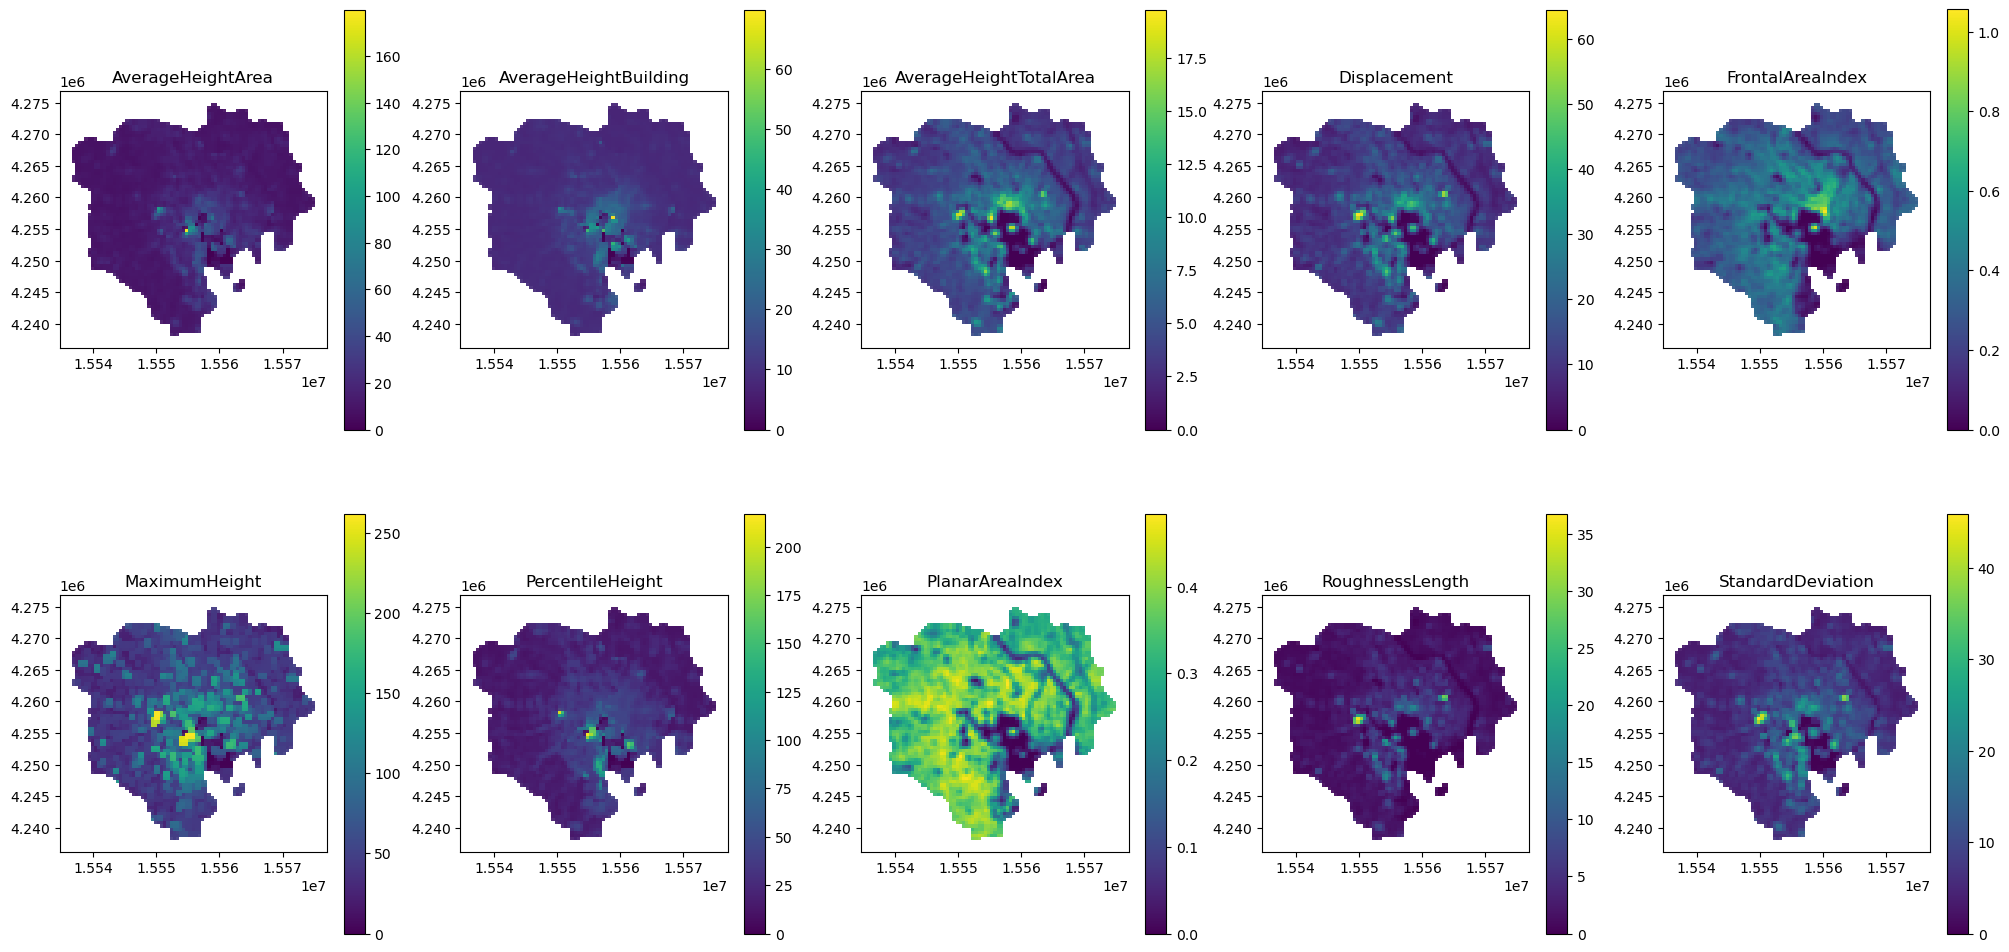

In [13]:
du.plotUMP(ds_tokyo.ump_df, n_col= 5)

### NY

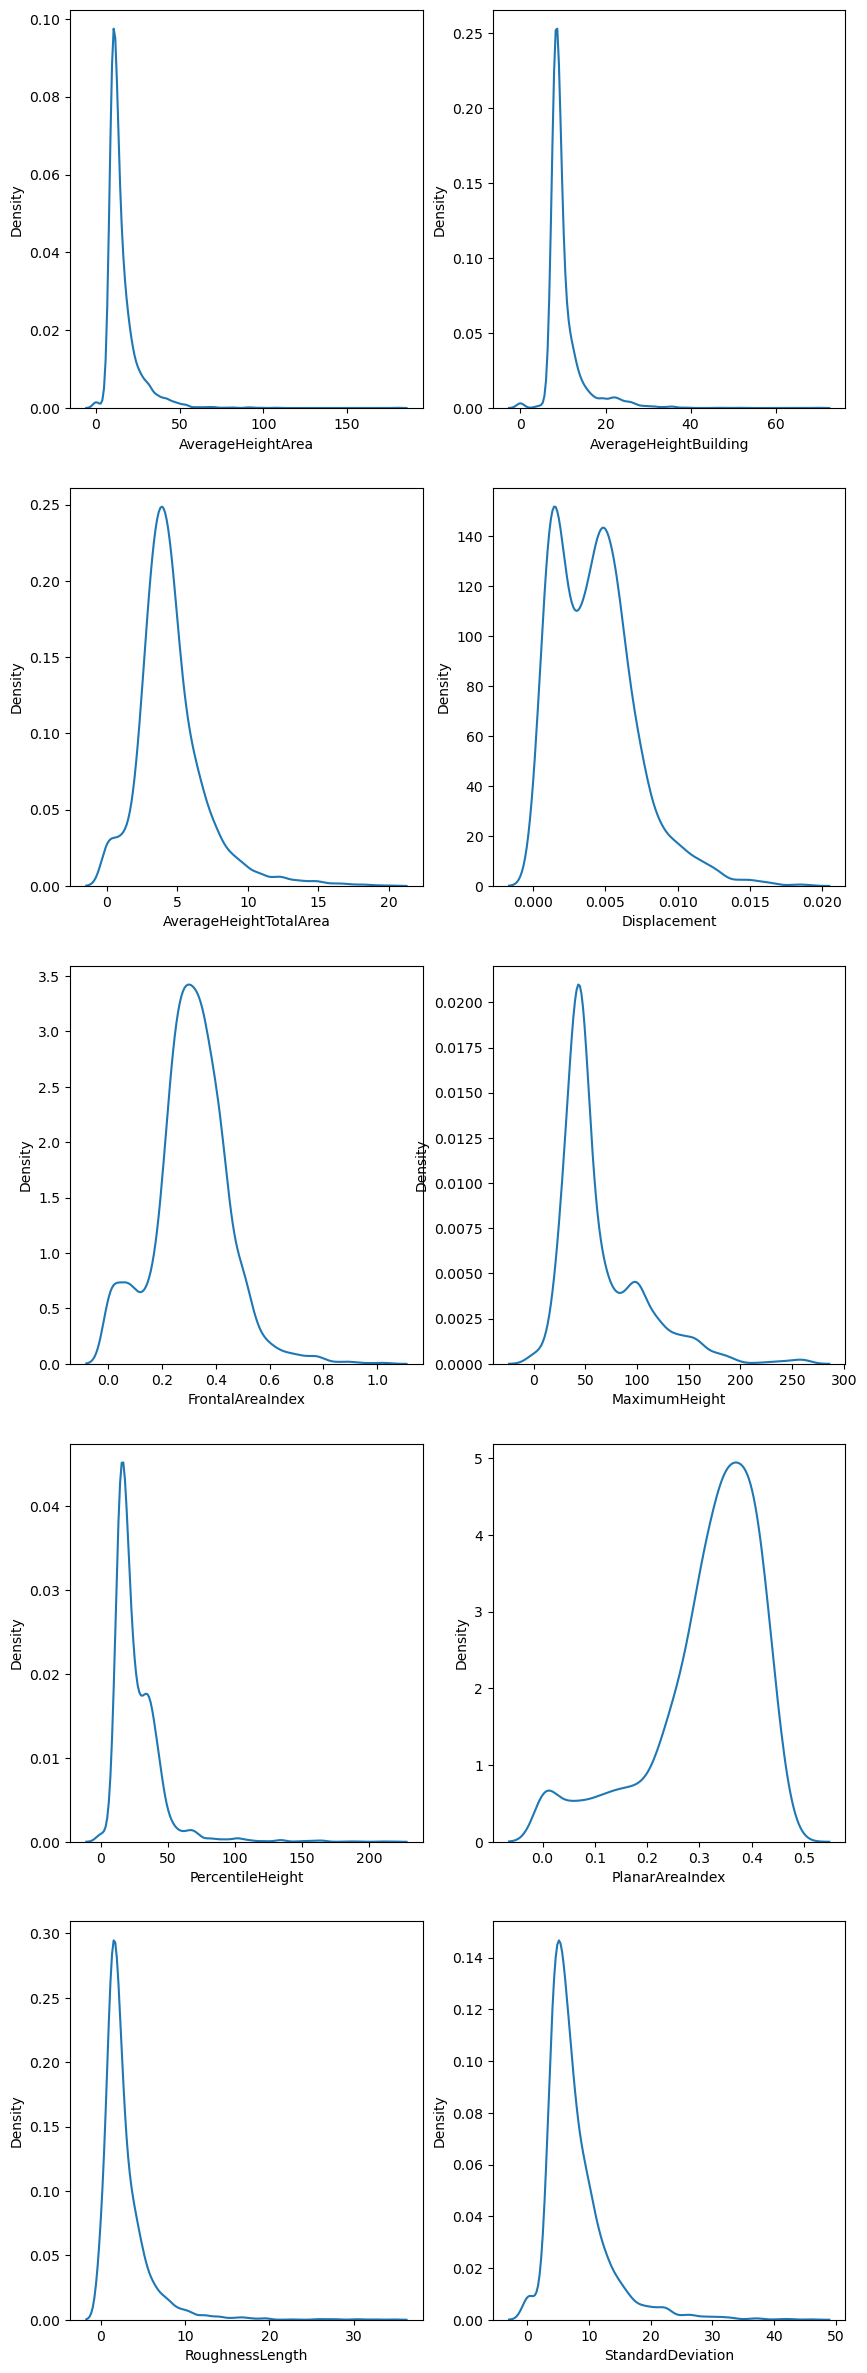

In [55]:
ump_count = 0

fig, axs = plt.subplots(5, 2, figsize= (10, 5*6))
for col in range(5):
    for row in range(2):
        f = plt.subplot(5, 2, ump_count+1)
        # f_img = gdf.plot(column= band_names[ump_count], alpha= 0.5, ax= axs[col, row], legend= True)
        f = sns.kdeplot(tokyo_gdf[UMP[ump_count]])
        # f_img.set_title(band_names[ump_count])
        # plt.title(band_names[ump_count])
        ump_count += 1
plt.show()


### NY

In [9]:
ny_gdf.columns

Index(['geometry', 'AverageHeightArea', 'AverageHeightBuilding',
       'AverageHeightTotalArea', 'Displacement', 'FrontalAreaIndex',
       'MaximumHeight', 'Percentile', 'PercentileHeight', 'PlanarAreaIndex',
       'RoughnessLength', 'StandardDeviation'],
      dtype='object')

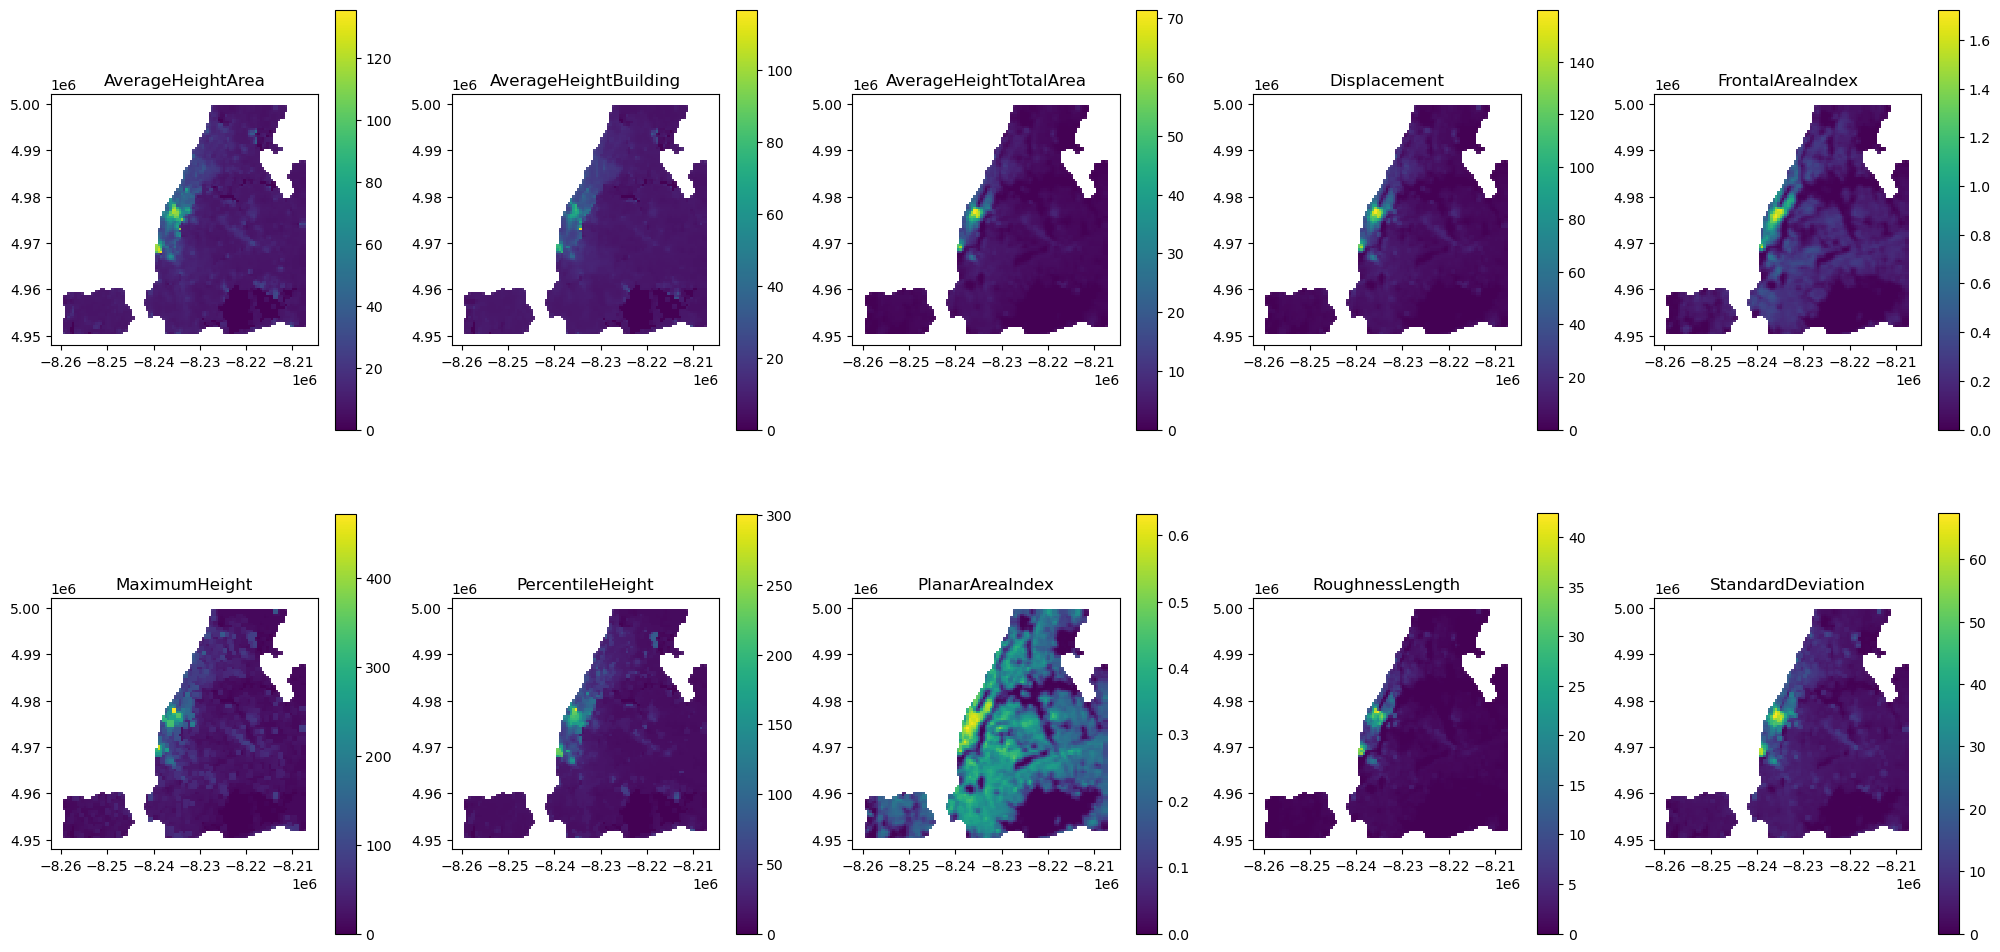

In [14]:
du.plotUMP(ds_ny.ump_df, n_col= 5)

# Plotting in feature maps and corresponding bands and height map

In [22]:
tokyo_gdf = gpd.read_feather("data/full_Tokyo_plateau/tokyo_fixed.feather")

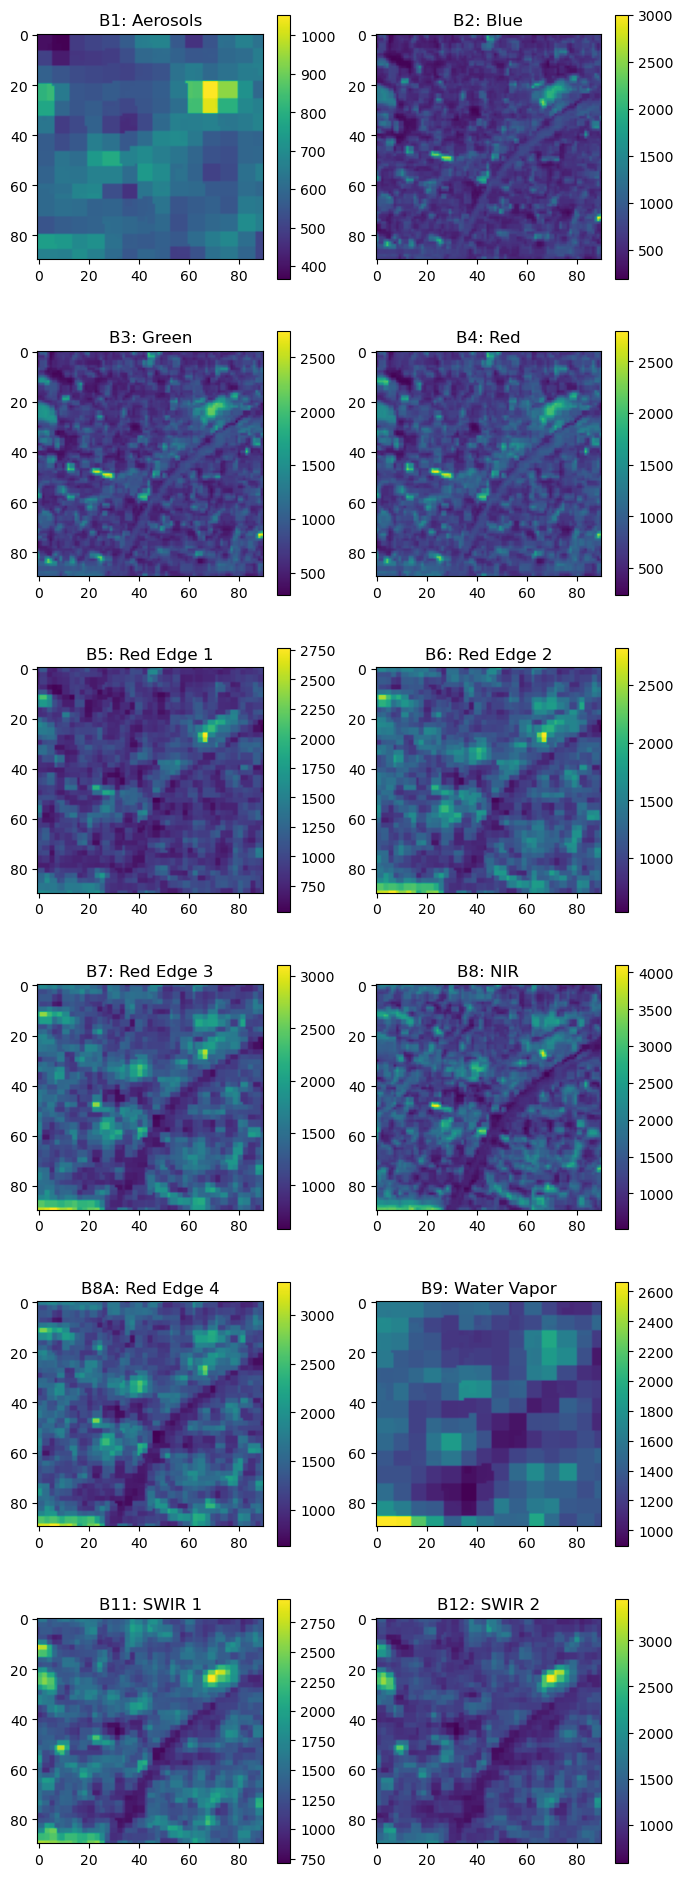

In [53]:
ds_tokyo.return_coords= True
idx = 0
bounds = ds_tokyo[idx][2]
bounds_poly = shapely.Polygon([(bounds[0], bounds[1]), 
        (bounds[0], bounds[3]), 
        (bounds[2], bounds[3]), 
        (bounds[2], bounds[1])])
img = ds_tokyo[idx][0]
tokyo_bg_gdf = pd.concat([gpd.GeoDataFrame(geometry= pd.Series([bounds_poly]), data= {"height": [-1]}), tokyo_gdf])
du.plotArray(img)

<AxesSubplot:>

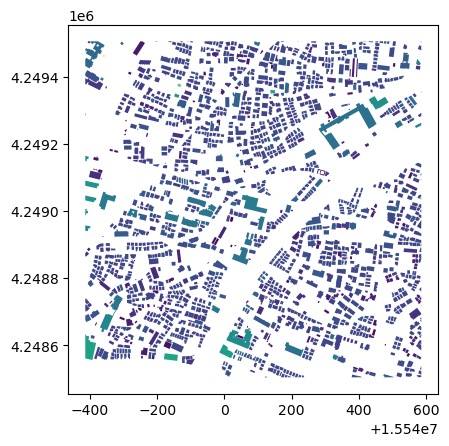

In [54]:
tokyo_gdf.clip(bounds_poly).plot(column= "height")

In [ ]:
tokyo_bg_gdf.clip(bounds_poly).plot(column= "height")

In [55]:
# Initialise the model
checkpoint = torch.load("overnight_results/model_4ump_20230505_001308_0_top", map_location="cuda:0")

# Rebuild the model
ssl._create_default_https_context = ssl._create_unverified_context
original_model = senet.senet154()
Encoder = modules.E_senet(original_model, ds_tokyo.channel_max)
model = net.model_n12_light(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048], n_out= 4, sigmoid_idx= [1, 2], cut_R2= True)

# Load in the weights
device = torch.device("cuda")
model.load_state_dict(checkpoint, strict=True)
model.to(device)
model.eval();

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

In [58]:
with torch.no_grad():
    feature_maps = model(torch.tensor(img, device= "cuda").unsqueeze(0))

In [67]:
feature_maps = feature_maps[0]

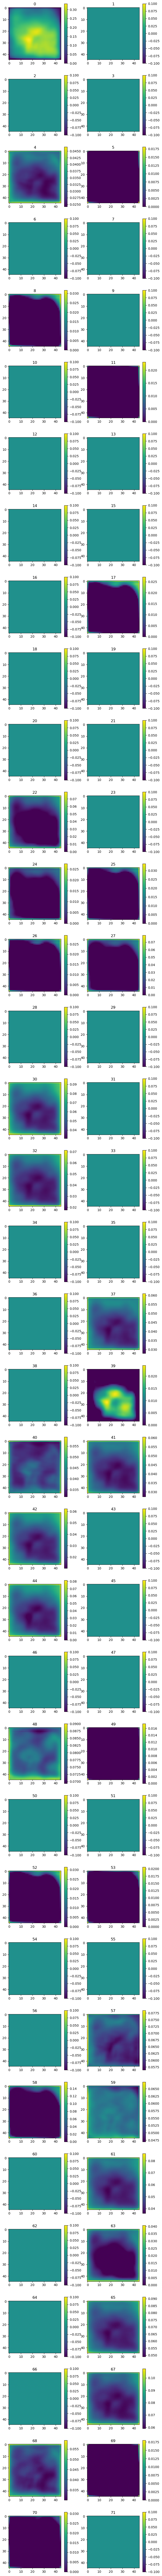

In [68]:
du.plotArray(feature_maps.cpu(), n_channels= len(feature_maps), band_names= [str(i) for i in range(len(feature_maps))])

# I love debugging

## Load and convert Datasets

In [9]:
# New Dataset
## Osaka
osaka_gdf = gpd.read_feather("data/Y_UMP/Y_osaka_4.feather")

## Tokyo
tokyo_gdf = gpd.read_feather("data/Y_UMP/Y_tokyo_4.feather")


# Old Dataset
labels_df = pd.read_csv("data/full_Tokyo_plateau/tokyo_ump.csv")
label_df_geom = labels_df.apply(lambda x: LL_polygon(x["x_coord"], x["y_coord"]), axis= 1)
label_df_gdf = gpd.GeoDataFrame(geometry= label_df_geom, data= labels_df.drop(labels_df.columns[:4], axis= 1)[UMP_OLD])

## Visualise train and split
### 15563169 is the x coord to split
old_train_gdf = label_df_gdf[label_df_gdf["geometry"].bounds["maxx"] < 15563169] 
old_valid_gdf = label_df_gdf[label_df_gdf["geometry"].bounds["minx"] > 15563169]

# There may be a few discrepancies between the gdfs and train/vals for the old dataset but shouldn't affect much as the values
# are still the same

with open("data/x_train_tokyo.pkl", "rb") as f:
    old_x_train = pickle.load(f)

with open("data/x_val_tokyo.pkl", "rb") as f:
    old_x_val = pickle.load(f)

with open("data/y_train_tokyo.pkl", "rb") as f:
    old_y_train = pickle.load(f)

with open("data/y_val_tokyo.pkl", "rb") as f:
    old_y_val = pickle.load(f)

# Reorder old_y_
# 0 - 1
# 1 - 0
# 2 - 2
# 3 - 7
# 4 - 4
# 5 - 5
# 6 - 6
# 7 - 3
old_y_train = old_y_train[:, [1, 0, 2, 7, 4, 5, 6, 3]]
old_y_val = old_y_val[:, [1, 0, 2, 7, 4, 5, 6, 3]]


In [10]:
# Convert to Dataset/Dataloaders
## New 
tokyo_ds = du.UMPDataset(tokyo_gdf, "data/X_sentinel/tokyo")
osaka_ds = du.UMPDataset(osaka_gdf, "data/X_sentinel/osaka")
new_dls = DataLoaders().from_dsets(tokyo_ds, osaka_ds, bs= 8, device=torch.device('cuda'))

## Old
old_dls = DataLoaders().from_dsets(list(zip(old_x_train, old_y_train)), list(zip(old_x_val, old_y_val)), bs= 8, device=torch.device('cuda'))


KeyError: 'Rotation'

## Sanity checks with LR

In [17]:
from sklearn.linear_model import LinearRegression

### Fit Linear Model

In [64]:
def LR_check(dataset, regs= None, labels= UMP):
    """
    Performs and visualises LinearRegression on a UMPDataset object.\n
    If regs is provided, no fitting will be done.\n
    # Parameters:
    - dataset: UMPDataset object
    - regs: List of LinearRegression objects that are assummed to have been fitted.
    - labels: List of String labels for the subplots
    """
    x_train = np.array([entry[0].mean((1, 2)) for entry in dataset])
    y_train = np.array([entry[1] for entry in dataset])

    if regs is None:
        regs = []
        for ump in range(8):
            reg = LinearRegression()
            reg.fit(x_train, y_train[:, ump]) 
            regs.append(reg)

    fig, axes = plt.subplots(4, 2, figsize= (30, 60))
    for ump in range(8):
        x = regs[ump].predict(x_train)
        # LR
        sns.scatterplot(x= x, y= y_train[:, ump], alpha= 0.5, ax= axes[ump//2, ump%2])

        # Baseline
        ax = sns.lineplot(x= y_train[:, ump], y = y_train[:, ump], ax= axes[ump//2, ump%2], color= "g")

        rmse_lr = math.sqrt(sklearn.metrics.mean_squared_error(x, y_train[:, ump]))
        ax.set(xlabel= "Predicted", ylabel= "Actual")
        axes[ump//2, ump%2].set_title(f"{labels[ump]}, RMSE: {rmse_lr}")
    
    return regs

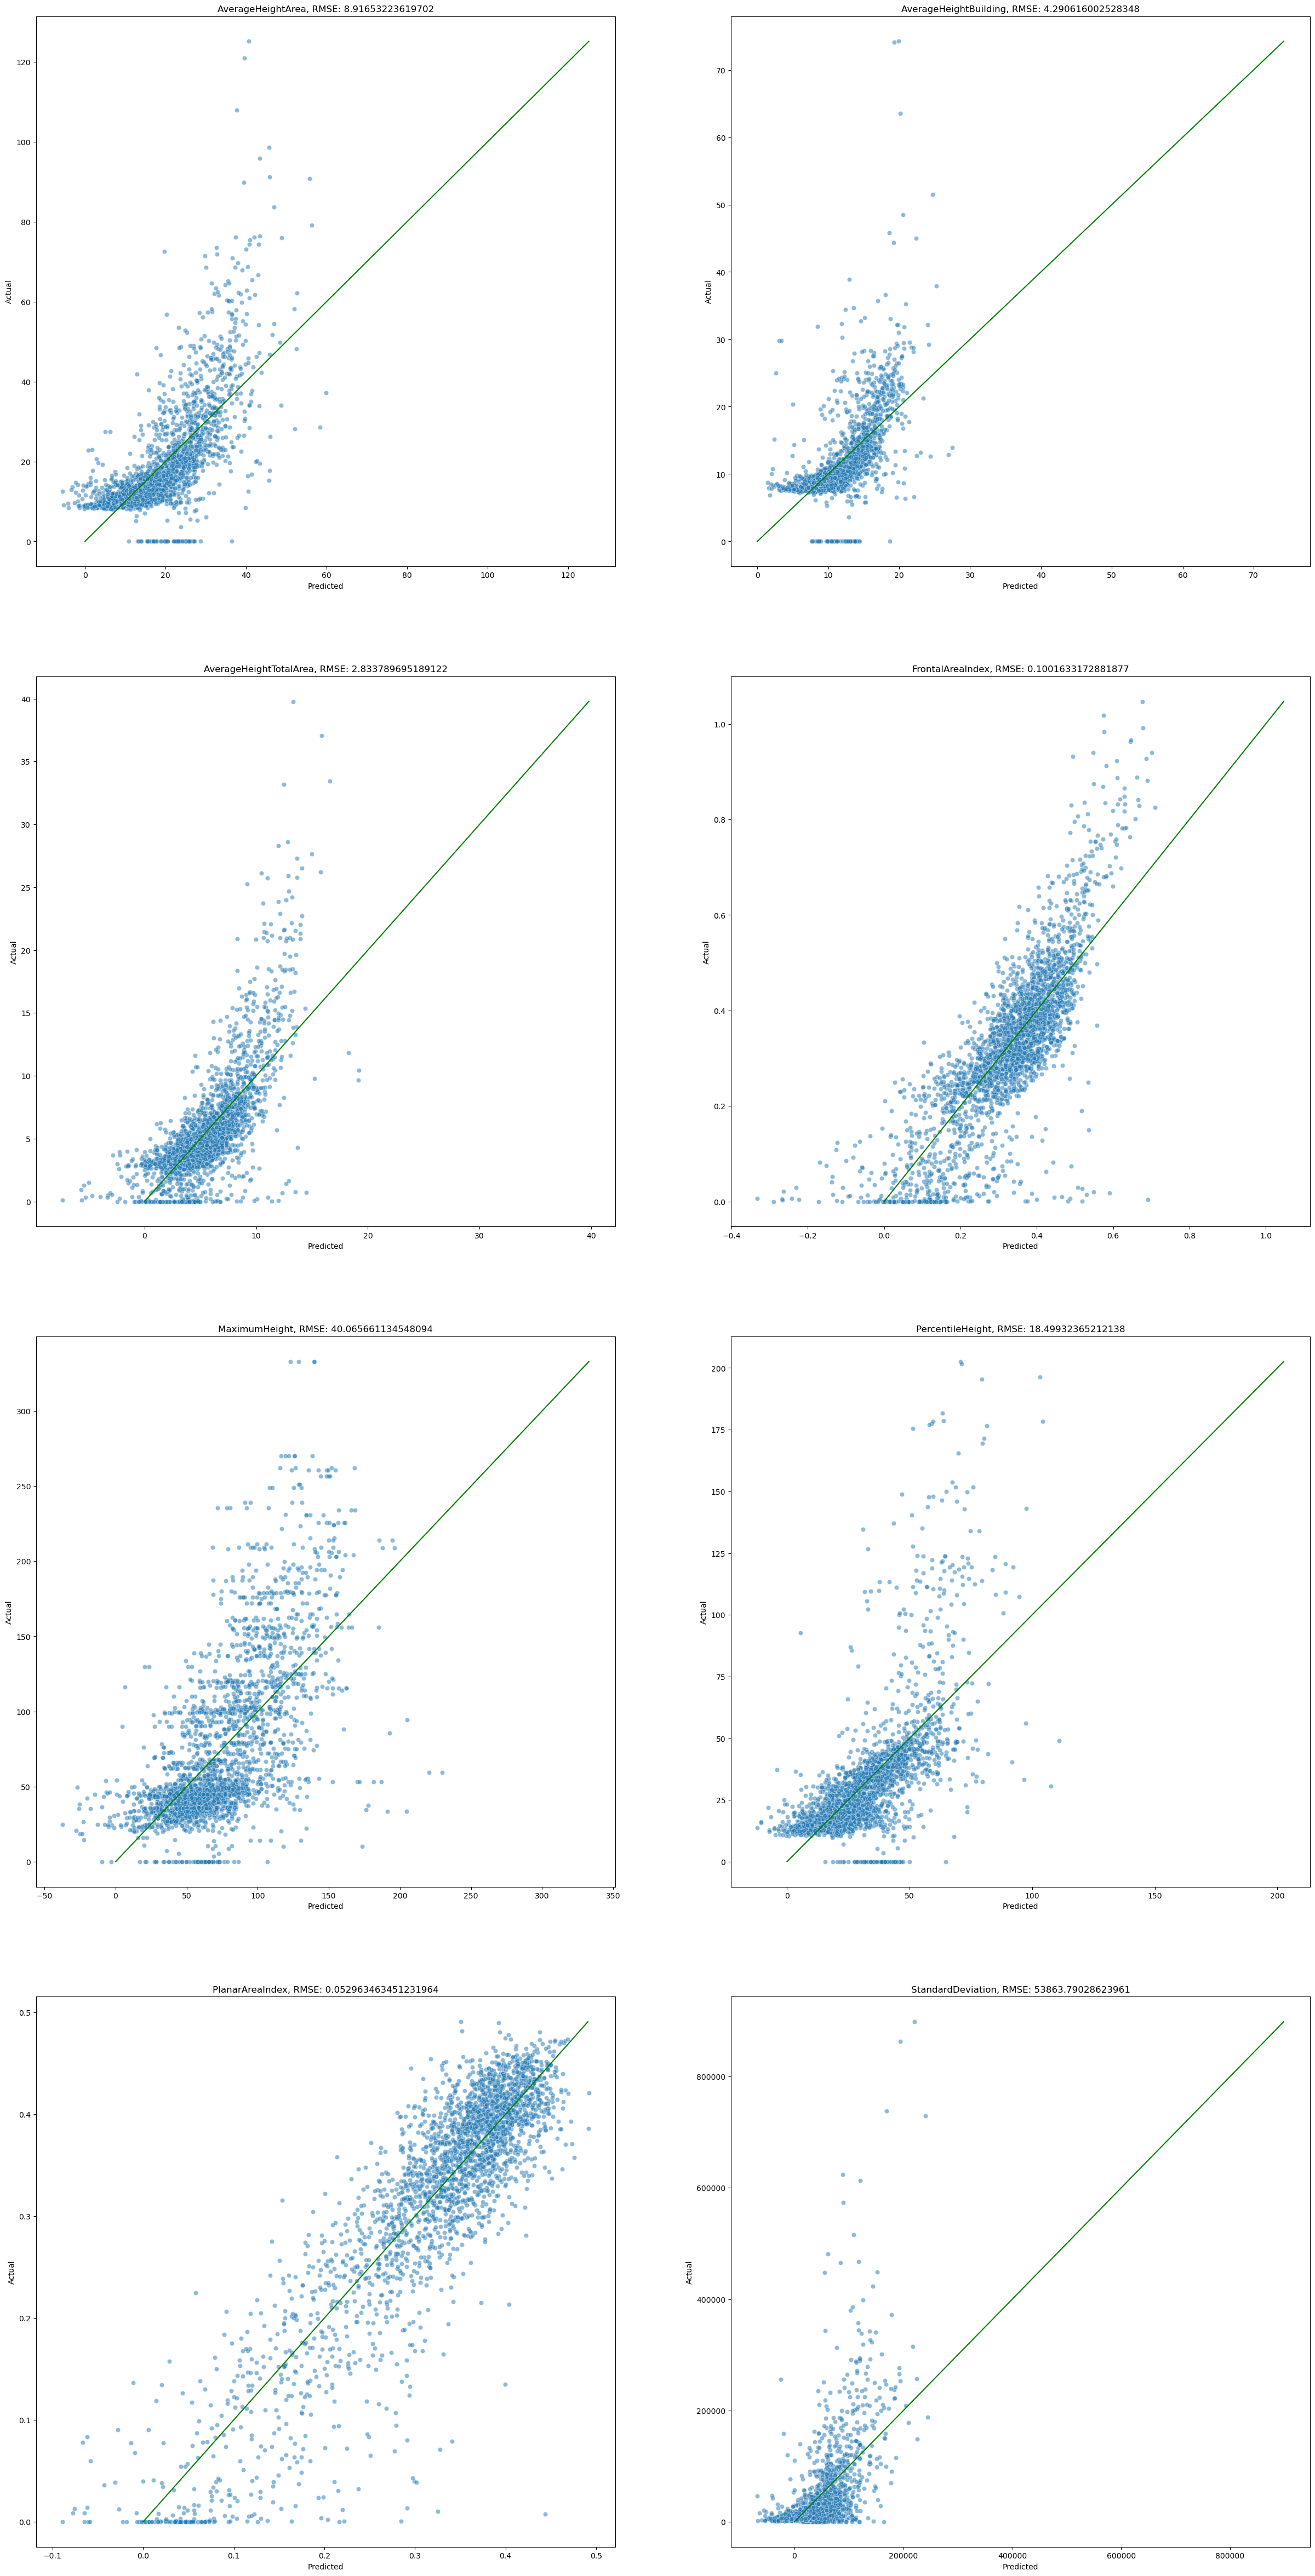

In [65]:
old_ds_regs = LR_check(old_dls.train_ds, labels= UMP);

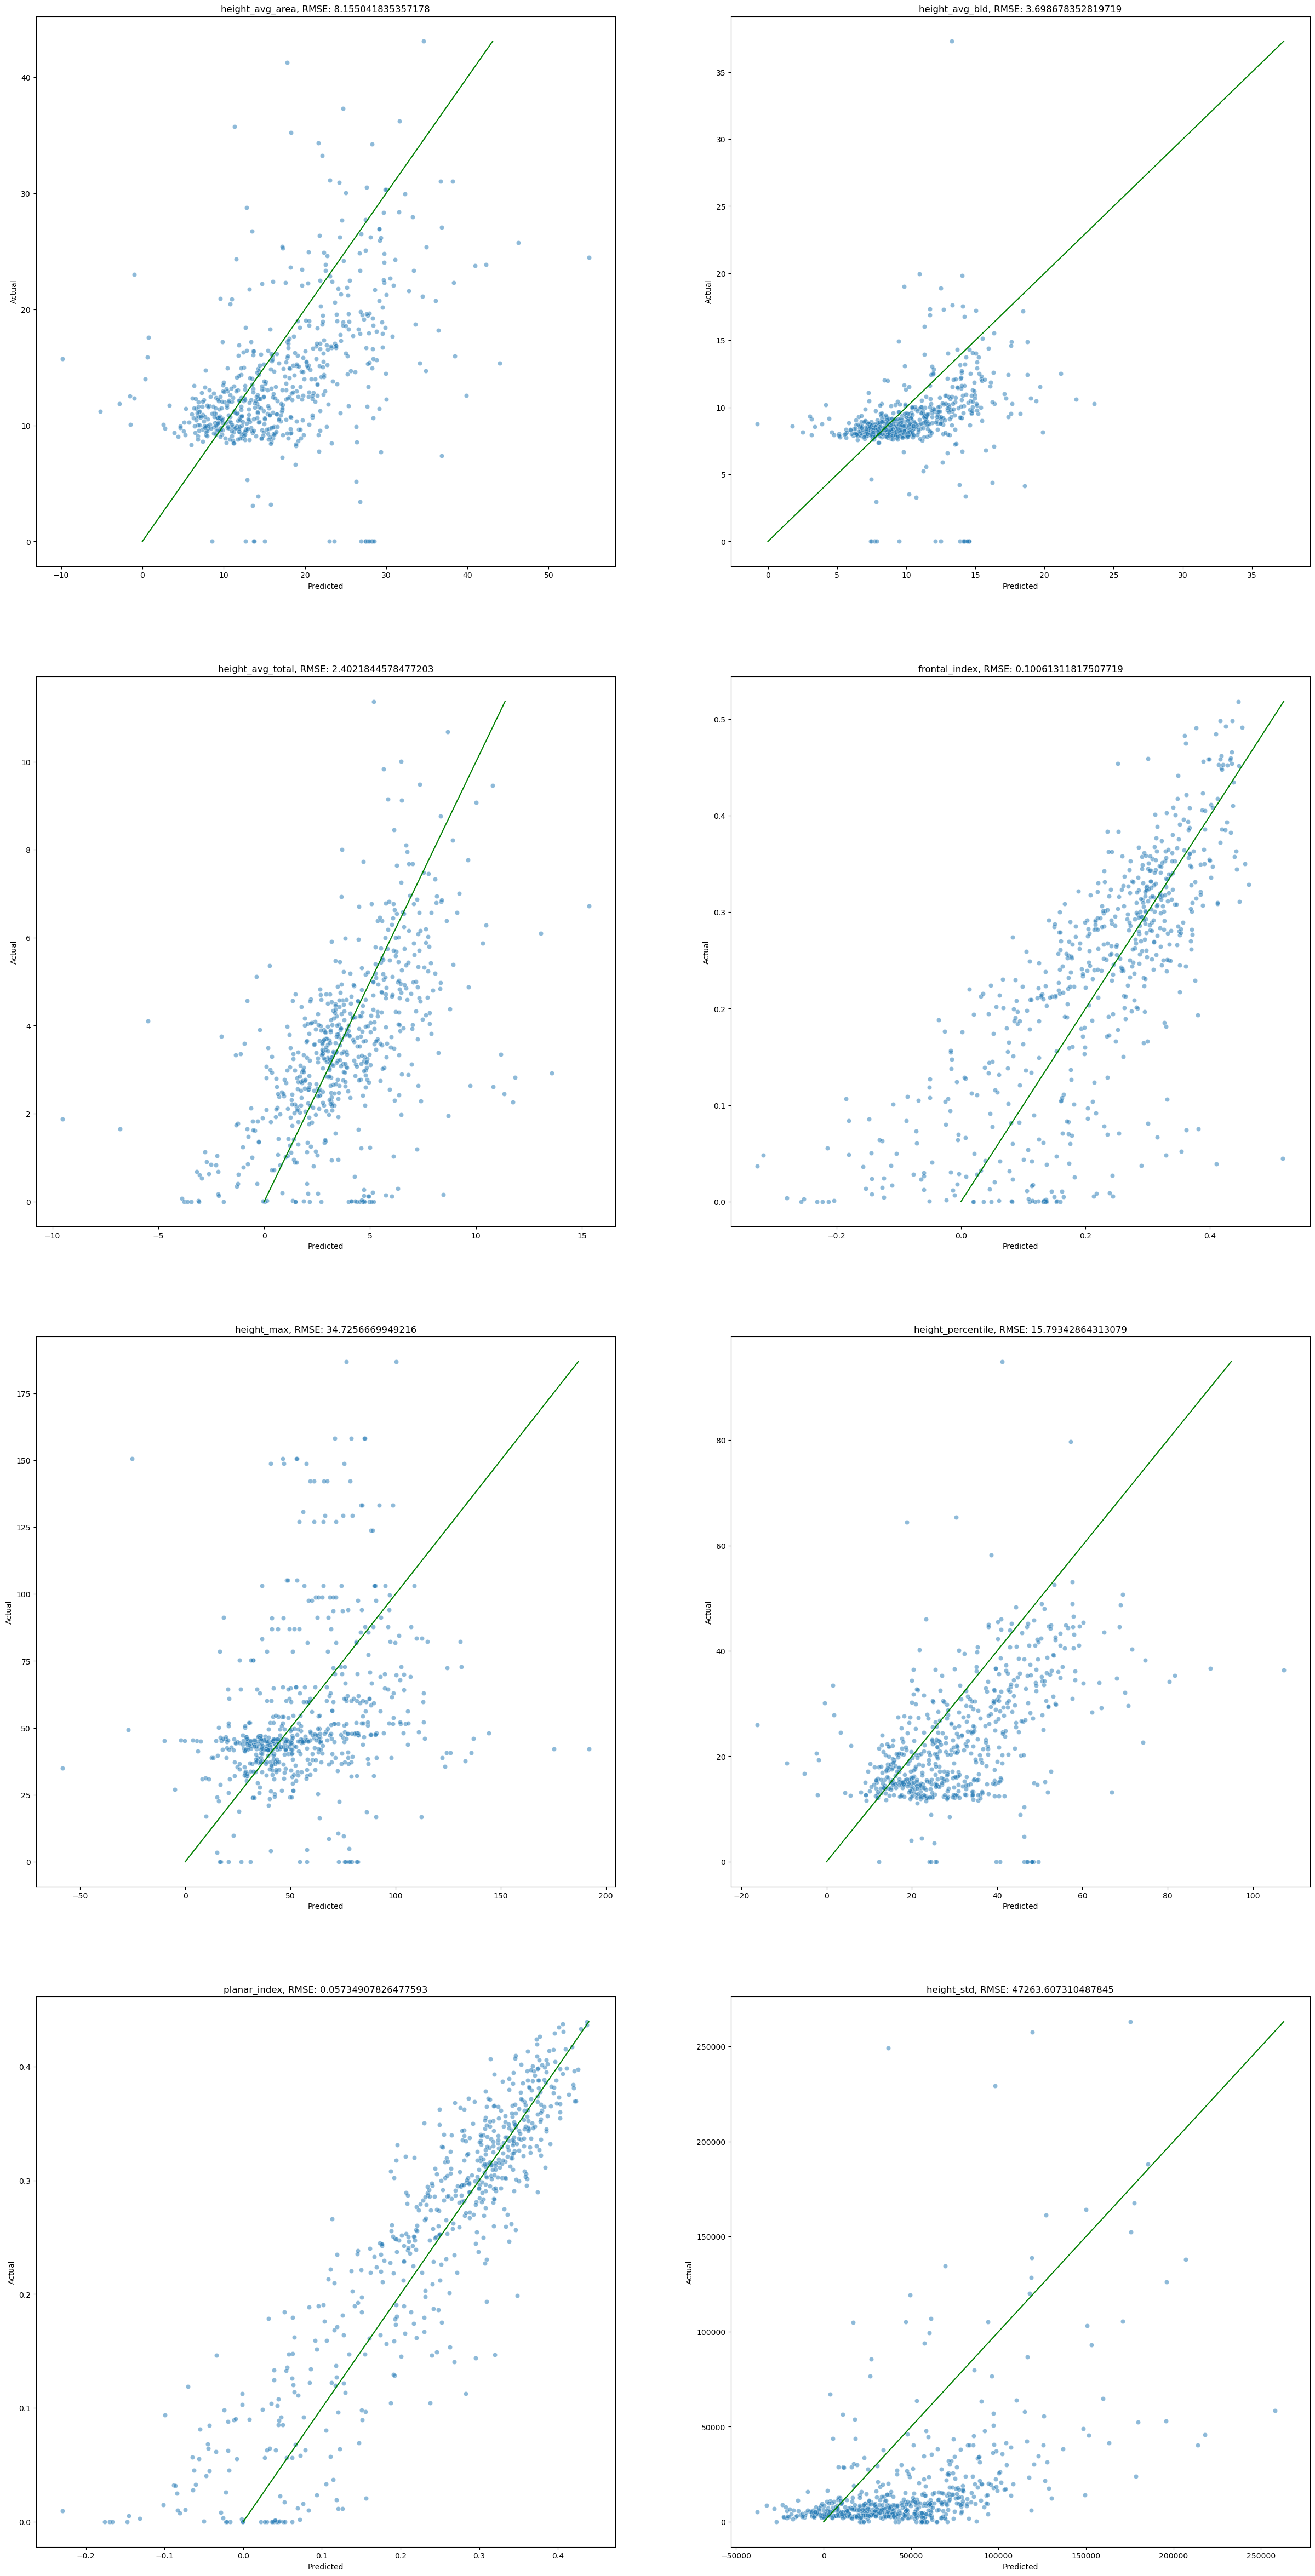

In [66]:
LR_check(old_dls.valid_ds, labels= UMP_OLD, regs= old_ds_regs);

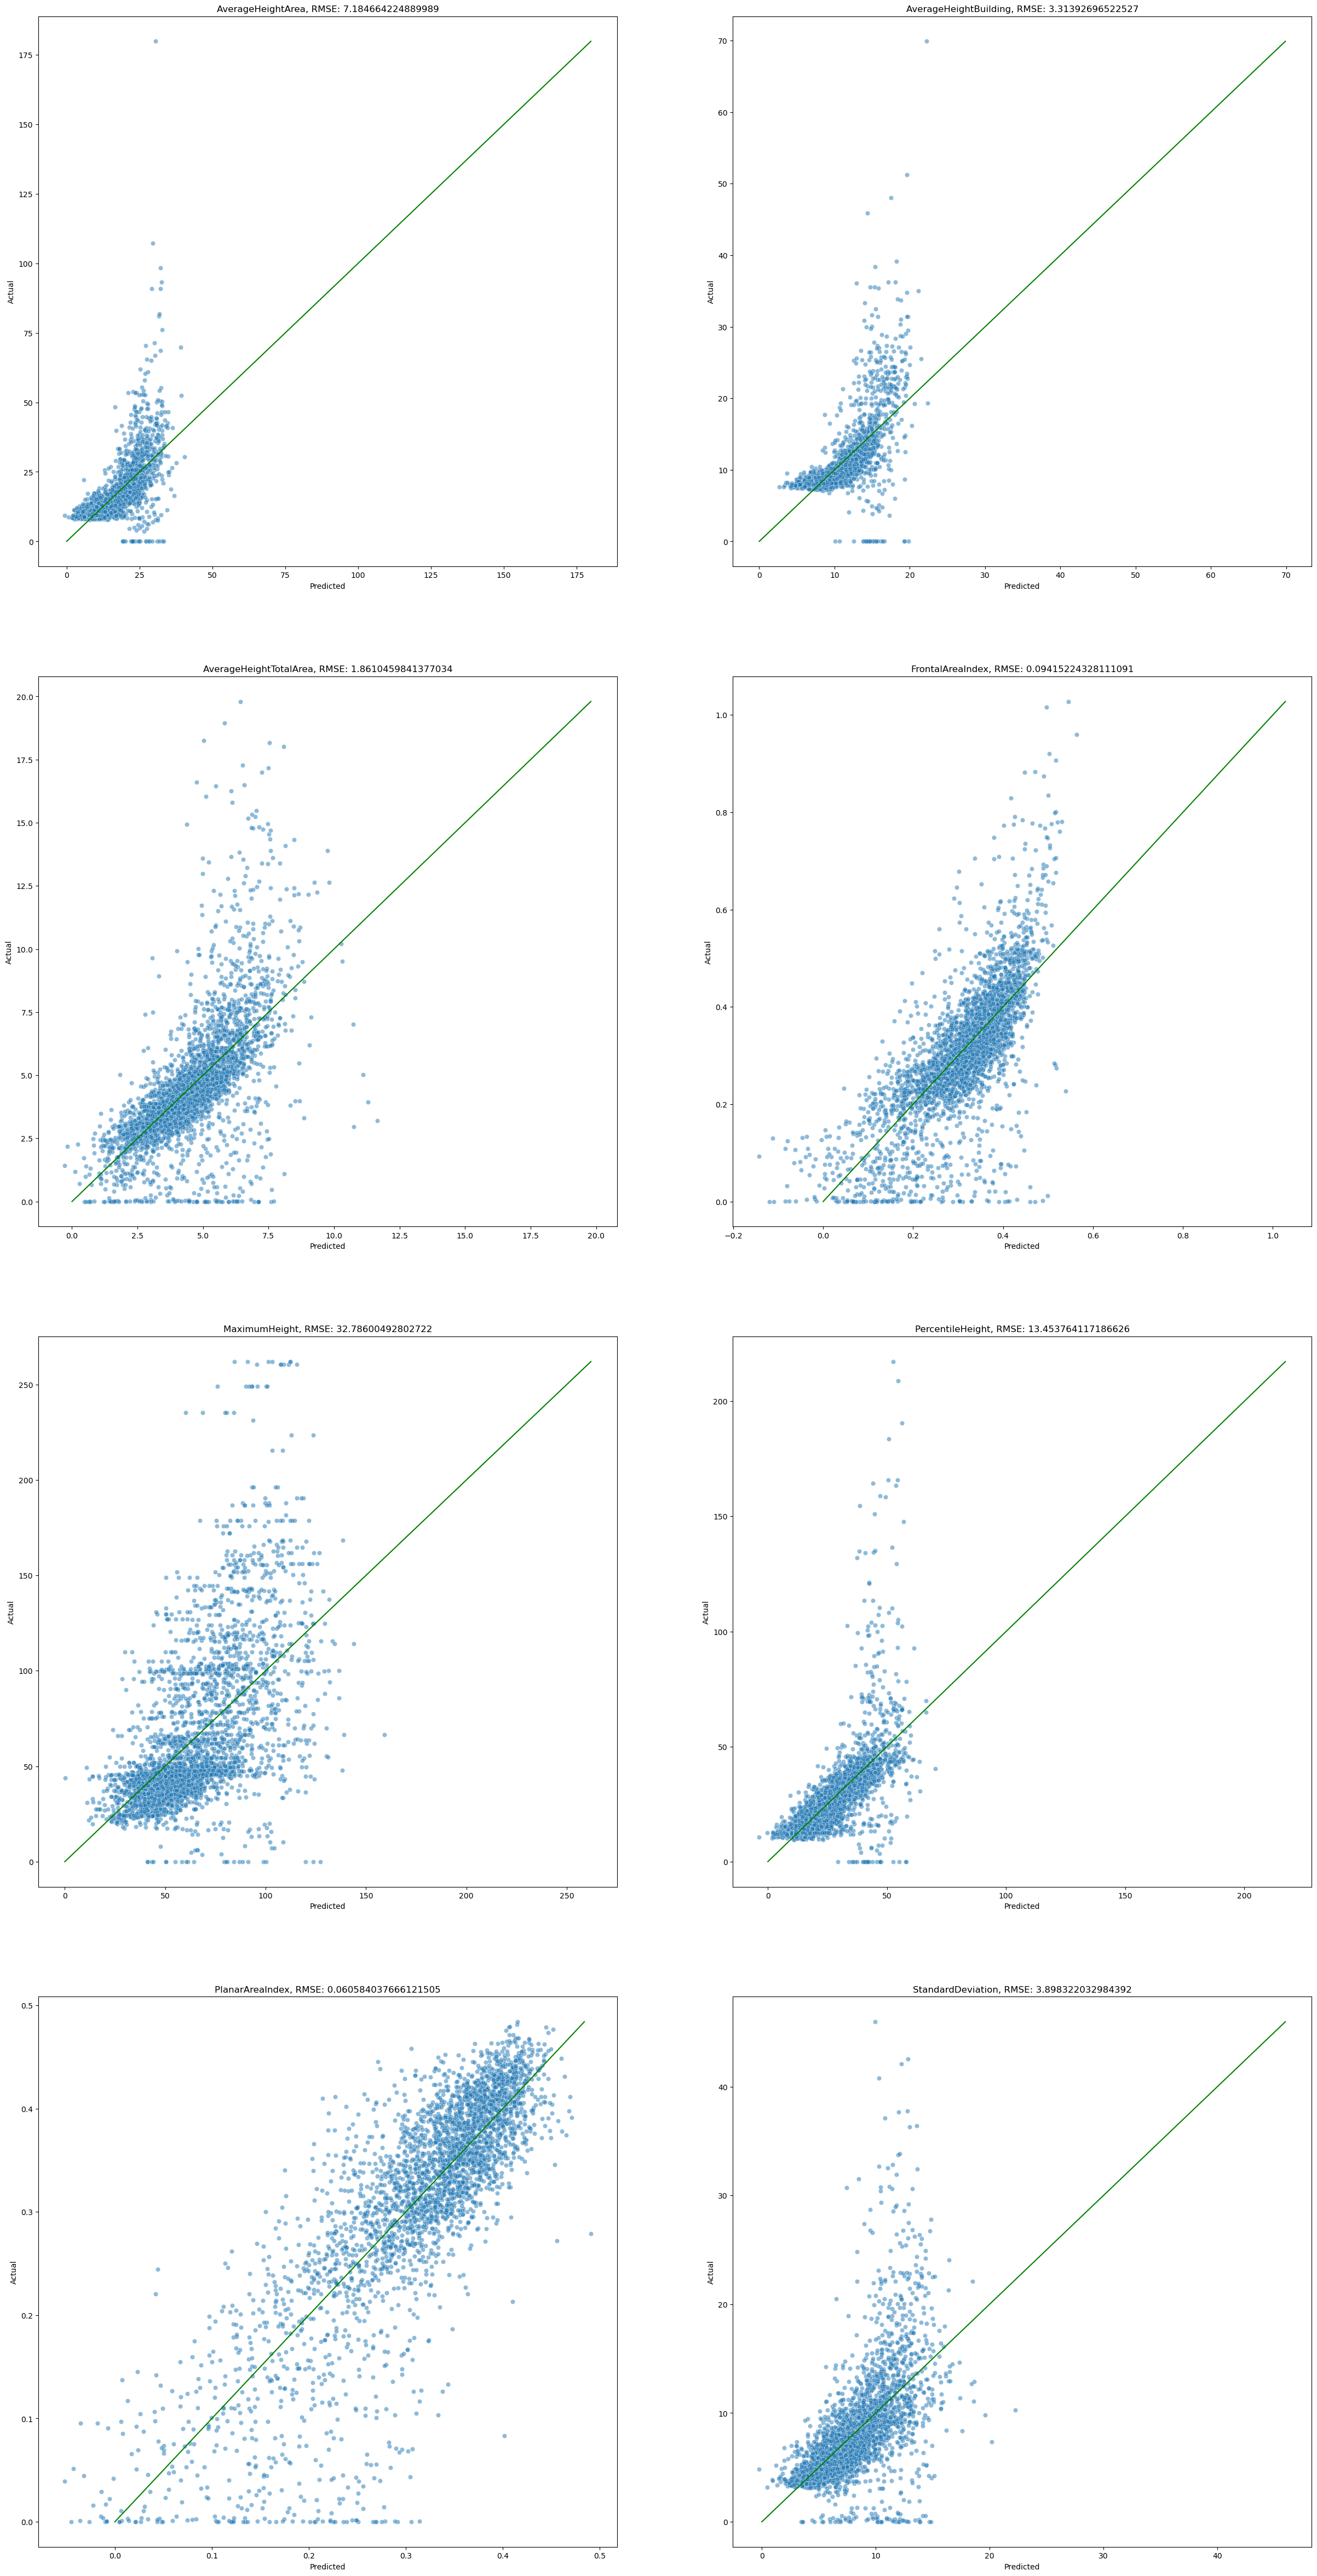

In [67]:
new_ds_regs = LR_check(new_dls.train_ds, labels= UMP)

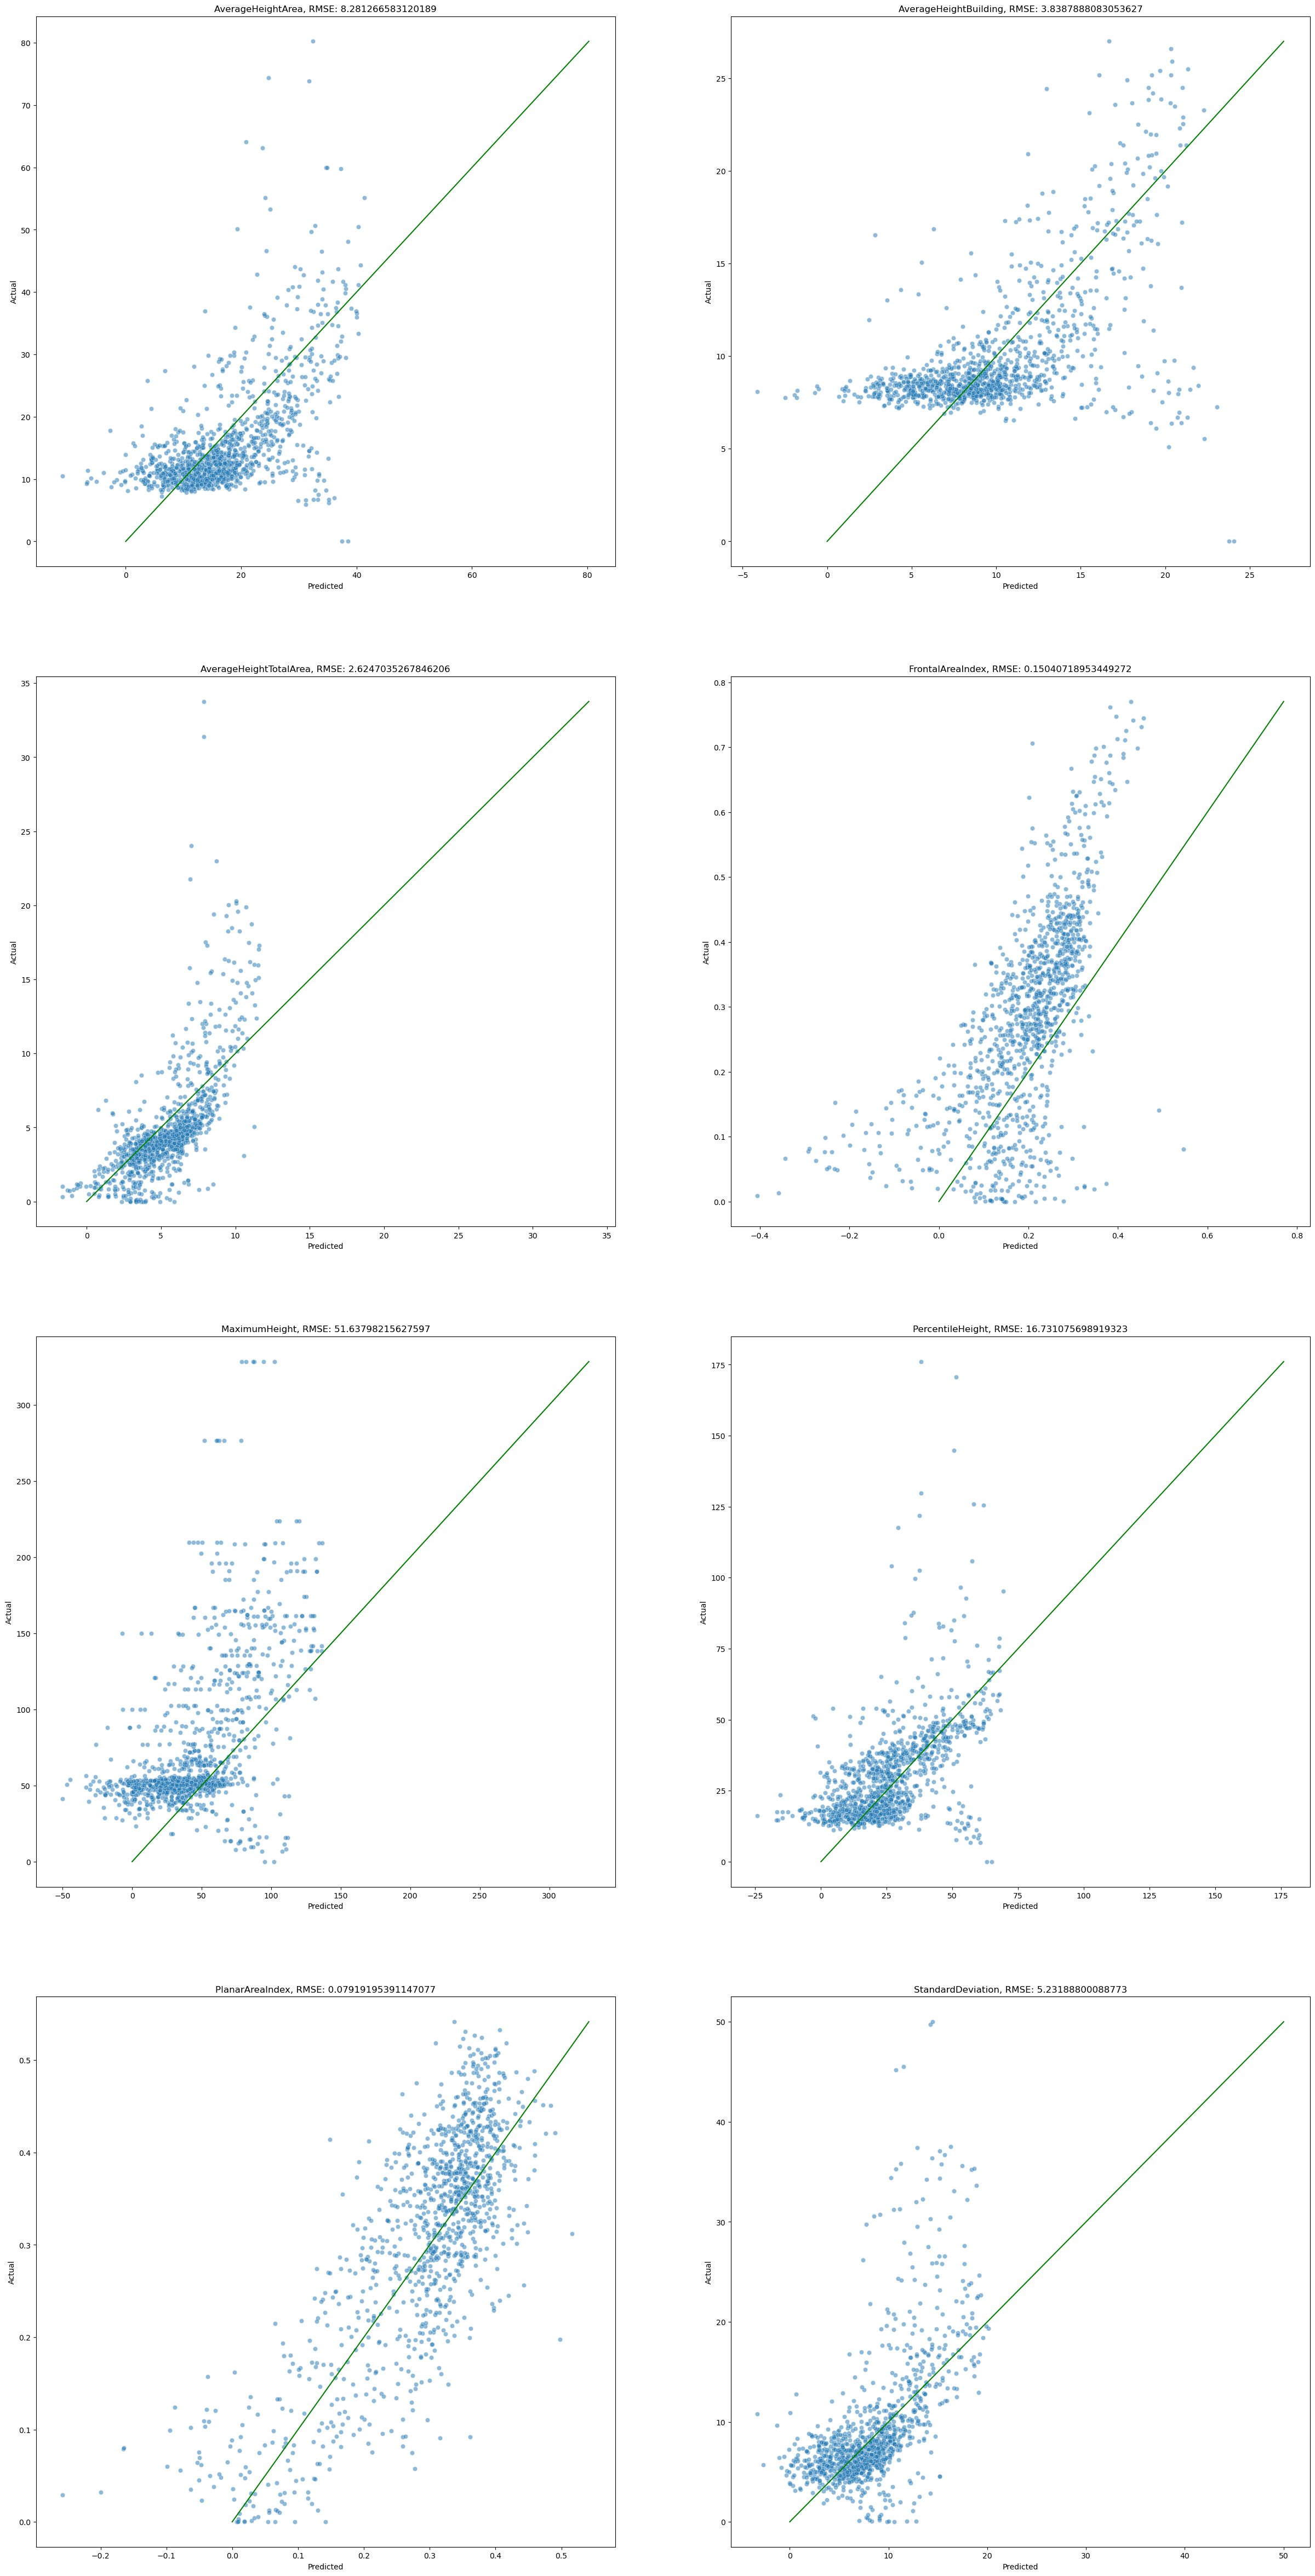

In [68]:
LR_check(new_dls.valid_ds, labels= UMP, regs= new_ds_regs);

# Visualising Records

In [12]:
# Loss Function

# def mse_weighted(pred, actual, UMP_max= old_ds_UMP_max):
# def mse_weighted(pred, actual, UMP_max= dl.train_ds.UMP_max):
def mse_weighted(pred, actual, UMP_max):
    """
    Weighted loss function that normalises the predictions based on the parameters used to normalise the actual during training
    """
    loss = tensor(0).float()
    loss.requires_grad_(True)
    for ump in range(pred.shape[1]):
        # loss = torch.add(loss, F.mse_loss(pred[:, ump], actual[:, ump]))
        loss = torch.add(loss, torch.div(F.mse_loss(pred[:, ump], actual[:, ump]), UMP_max[ump]**2))
    if loss.isnan().sum() > 1:
        raise ValueError([pred, actual])
    return loss.float()

# List of metrics
"""
"AverageHeightArea", 
"AverageHeightBuilding", 
"AverageHeightTotalArea", 
"Displacement", 
"FrontalAreaIndex",
"MaximumHeight",
"PercentileHeight",
"PlanarAreaIndex",
"RoughnessLength",
"StandardDeviation"
"""
def AverageHeightArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 0], actual[:, 0]))

def AverageHeightBuilding_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 1], actual[:, 1]))

def AverageHeightTotalArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 2], actual[:, 2]))

# def Displacement_RMSE(pred, actual):
#     return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))

def FrontalAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))
    # return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))

def MaximumHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))
    # return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))

def PercentileHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))
    # return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))

def PlanarAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))
    # return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))

# def RoughnessLength_RMSE(pred, actual):
#     return math.sqrt(F.mse_loss(pred[:, 8], actual[:, 8]))

def StandardDeviation_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))
    # return math.sqrt(F.mse_loss(pred[:, 9], actual[:, 9]))

metrics = [
    AverageHeightArea_RMSE, 
    AverageHeightBuilding_RMSE,
    AverageHeightTotalArea_RMSE,
    # Displacement_RMSE,
    FrontalAreaIndex_RMSE,
    MaximumHeight_RMSE,
    PercentileHeight_RMSE,
    PlanarAreaIndex_RMSE,
    # RoughnessLength_RMSE,
    StandardDeviation_RMSE
]

In [13]:
# Import records
record_path = "overnight_results/recorder_12ch_light_Toyko_Osaka_64_30.pkl"
with open(record_path, "rb") as f:
    record = pickle.load(f)


AttributeError: 'model_n12_light' object has no attribute 'values'